--- 

<h2>PREPROCESAMIENTO DE LOS DATOS Y CREACIÓN DE LOS MAPAS</h2>

<h2>Autor: Alex Chaume</h2>

---

## 1. Importación de librerías

In [42]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from IPython.display import clear_output
import folium
import geopandas as gpd
import imgkit
import io
from PIL import Image
import matplotlib.pyplot as plt
import selenium

## 2. Carga de datos

In [2]:
# from google.colab import drive
# drive.mount('/content/Drive')

In [43]:
# Cargamos el csv

#movimientos = pd.read_csv("/content/Drive/MyDrive/NOVIEMBRE-1SEM-FINDE.csv")

movimientos = pd.read_csv("datos/DICIEMBRE-SEM3.csv")

In [44]:
print(movimientos["timestamp_from"].min(),movimientos["timestamp_from"].max()) #datos de 5 dias laborales

2023-12-11 00:05:00 2023-12-17 23:59:59


In [45]:
movimientos.shape

(34977138, 16)

In [46]:
movimientos.head()

,Unnamed: 0,datatype,filtertime,key,area_from,area_to,diff_time,id_component_from,id_component_to,latitude_from,latitude_to,longitude_from,longitude_to,timestamp_from,timestamp_to,value_hash
0,0,movement,20231211235956090,1.702829e+09,alaquas,naquera,219934,WifiBluDetectorALSCTMC0005,WifiBluDetectorNAACTMC0002,39.456615,39.657394,-0.460813,-0.403744,2023-12-11 23:59:56,2023-12-14 13:05:30,0007458F
1,1,movement,20231211235918026,1.702825e+09,torrent,sieteaguas,148798,WifiBluDetectorTOCTMC0011,WifiBluDetectorSISCTMC0002,39.431026,39.472912,-0.472325,-0.914791,2023-12-11 23:59:18,2023-12-13 17:19:16,000E0D8F
2,2,movement,20231211235909771,1.702825e+09,belgida,alcasser,136459,WifiBluDetectorBEGCTMC0002,WifiBluDetectorASRCTMC0004,38.857605,39.366104,-0.474506,-0.446075,2023-12-11 23:59:09,2023-12-13 13:53:28,000A44AC
3,3,movement,20231211235810909,1.702826e+09,alboraya,anna,151852,WifiBluDetectorAYACTMC0003,WifiBluDetectorANNCTMC0003,39.499256,39.018150,-0.350002,-0.646761,2023-12-11 23:58:10,2023-12-13 18:09:02,000761CF
4,4,movement,20231211235737446,1.702825e+09,burjassot,alaquas,149852,WifiBluDetectorBUTCTMC0003,WifiBluDetectorALSCTMC0010,39.508247,39.452164,-0.418562,-0.465646,2023-12-11 23:57:37,2023-12-13 17:35:09,0003F2A1


CHUNK PARA CALCULAR LA DIFERENCIA DE TIEMPO DE CADA MOVIMIENTO

In [47]:
movimientos['timestamp_from'] = pd.to_datetime(movimientos['timestamp_from'])
movimientos['timestamp_to'] = pd.to_datetime(movimientos['timestamp_to'])
movimientos['Diferencia'] = (np.abs(movimientos['timestamp_from'] - movimientos['timestamp_to']).dt.total_seconds()).astype(int)

Para agilizar la rutina no hemos comprobado Diferencia con diff_time por lo que asumimos que nuestra diferencia está bien calculada y hacemos los intervalos con ella

CHUNKs PARA UNIR TABLA MAESTRA CON MOVIMIENTOS Y ASI ASOCIAR A CADA COMPONENTE DE CADA MOVIMIENTO SU MUNICIPIO COMO STRING Y COMO ENTERO

In [48]:
movimientos = movimientos.drop(["datatype"],axis=1)

In [49]:
movimientos = movimientos.drop(["diff_time"],axis=1)

In [50]:
movimientos = movimientos.drop(["key"],axis=1)

In [51]:
movimientos = movimientos.rename(columns={"area_from":"Municipio_Origen","area_to":"Municipio_Destino"})

movimientos = movimientos.sort_values(by='Municipio_Origen')
movimientos['Origen'] = pd.factorize(movimientos['Municipio_Origen'])[0]

In [52]:
mapeo_destino = movimientos[['Municipio_Origen', 'Origen']].drop_duplicates().set_index('Municipio_Origen')

# Usa el mapeo para asignar identificadores únicos a 'Municipio_Destino' y crea una nueva columna 'Destino'
movimientos['Destino'] = movimientos['Municipio_Destino'].map(mapeo_destino['Origen']).dropna().astype(int)

In [53]:
movimientos.head()

,Unnamed: 0,filtertime,Municipio_Origen,Municipio_Destino,id_component_from,id_component_to,latitude_from,latitude_to,longitude_from,longitude_to,timestamp_from,timestamp_to,value_hash,Diferencia,Origen,Destino
22221272,8636814,20231215122616520,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0012,WifiBluDetectorALPCTMC0001,40.060638,39.541542,-1.283678,-0.387540,2023-12-15 12:26:16,2023-12-15 15:19:06,00002A7F,10370,0,22
31636346,3400525,20231217163337173,ademuz,xativa,WifiBluDetectorADZCTMC0007,WifiBluDetectorXAACTMC0008,40.061249,38.990429,-1.286604,-0.515916,2023-12-17 16:33:37,2023-12-17 17:28:00,0002DE15,3263,0,248
31636343,3400522,20231217163337174,ademuz,algemesi,WifiBluDetectorADZCTMC0007,WifiBluDetectorASICTMC0005,40.061249,39.190964,-1.286604,-0.436836,2023-12-17 16:33:37,2023-12-17 18:01:55,000B0A39,5298,0,27
31636342,3400521,20231217163337177,ademuz,algardepalancia,WifiBluDetectorADZCTMC0007,WifiBluDetectorAIACTMC0001,40.061249,39.781380,-1.286604,-0.367780,2023-12-17 16:33:37,2023-12-17 16:58:02,0006CCC7,1465,0,26
3325651,2598116,20231213102838012,ademuz,tavernesdelavalldigna,WifiBluDetectorADZCTMC0013,WifiBluDetectorTANCTMC0011,40.060802,39.077282,-1.276627,-0.251933,2023-12-13 10:28:38,2023-12-13 12:16:45,000FC352,6487,0,226


In [54]:
print(np.sum(movimientos['Origen'] == movimientos['Destino']))

#Eliminamos desplazamientos entre municipios iguales:

movimientos_final = movimientos[movimientos['Municipio_Origen'] != movimientos['Municipio_Destino']]


print(np.sum(movimientos_final['Municipio_Origen'] == movimientos_final['Municipio_Destino']))


3472286
0


In [55]:
movimientos_final.head()

,Unnamed: 0,filtertime,Municipio_Origen,Municipio_Destino,id_component_from,id_component_to,latitude_from,latitude_to,longitude_from,longitude_to,timestamp_from,timestamp_to,value_hash,Diferencia,Origen,Destino
22221272,8636814,20231215122616520,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0012,WifiBluDetectorALPCTMC0001,40.060638,39.541542,-1.283678,-0.387540,2023-12-15 12:26:16,2023-12-15 15:19:06,00002A7F,10370,0,22
31636346,3400525,20231217163337173,ademuz,xativa,WifiBluDetectorADZCTMC0007,WifiBluDetectorXAACTMC0008,40.061249,38.990429,-1.286604,-0.515916,2023-12-17 16:33:37,2023-12-17 17:28:00,0002DE15,3263,0,248
31636343,3400522,20231217163337174,ademuz,algemesi,WifiBluDetectorADZCTMC0007,WifiBluDetectorASICTMC0005,40.061249,39.190964,-1.286604,-0.436836,2023-12-17 16:33:37,2023-12-17 18:01:55,000B0A39,5298,0,27
31636342,3400521,20231217163337177,ademuz,algardepalancia,WifiBluDetectorADZCTMC0007,WifiBluDetectorAIACTMC0001,40.061249,39.781380,-1.286604,-0.367780,2023-12-17 16:33:37,2023-12-17 16:58:02,0006CCC7,1465,0,26
3325651,2598116,20231213102838012,ademuz,tavernesdelavalldigna,WifiBluDetectorADZCTMC0013,WifiBluDetectorTANCTMC0011,40.060802,39.077282,-1.276627,-0.251933,2023-12-13 10:28:38,2023-12-13 12:16:45,000FC352,6487,0,226


In [56]:
movimientos_final['dia_semana'] = movimientos_final['timestamp_from'].dt.day_name() #sacamos dia de la semana

C:\Users\Alex\AppData\Local\Temp\ipykernel_10968\1922290488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movimientos_final['dia_semana'] = movimientos_final['timestamp_from'].dt.day_name() #sacamos dia de la semana


In [57]:
movimientos_final.head()

,Unnamed: 0,filtertime,Municipio_Origen,Municipio_Destino,id_component_from,id_component_to,latitude_from,latitude_to,longitude_from,longitude_to,timestamp_from,timestamp_to,value_hash,Diferencia,Origen,Destino,dia_semana
22221272,8636814,20231215122616520,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0012,WifiBluDetectorALPCTMC0001,40.060638,39.541542,-1.283678,-0.387540,2023-12-15 12:26:16,2023-12-15 15:19:06,00002A7F,10370,0,22,Friday
31636346,3400525,20231217163337173,ademuz,xativa,WifiBluDetectorADZCTMC0007,WifiBluDetectorXAACTMC0008,40.061249,38.990429,-1.286604,-0.515916,2023-12-17 16:33:37,2023-12-17 17:28:00,0002DE15,3263,0,248,Sunday
31636343,3400522,20231217163337174,ademuz,algemesi,WifiBluDetectorADZCTMC0007,WifiBluDetectorASICTMC0005,40.061249,39.190964,-1.286604,-0.436836,2023-12-17 16:33:37,2023-12-17 18:01:55,000B0A39,5298,0,27,Sunday
31636342,3400521,20231217163337177,ademuz,algardepalancia,WifiBluDetectorADZCTMC0007,WifiBluDetectorAIACTMC0001,40.061249,39.781380,-1.286604,-0.367780,2023-12-17 16:33:37,2023-12-17 16:58:02,0006CCC7,1465,0,26,Sunday
3325651,2598116,20231213102838012,ademuz,tavernesdelavalldigna,WifiBluDetectorADZCTMC0013,WifiBluDetectorTANCTMC0011,40.060802,39.077282,-1.276627,-0.251933,2023-12-13 10:28:38,2023-12-13 12:16:45,000FC352,6487,0,226,Wednesday


In [58]:
np.sum([movimientos_final['Municipio_Origen'] == "valencia"])

0

## 3. Unir tablas auxiliares

UNIMOS LA TABLA INFOMUNICIPIOS PARA PODER TENER MAS VARIABLES Y ASI PODER HACER UNA CLASIFICACION MAS FINA DE ANOMALOS Y NORMALES

In [59]:
infomunicipios = pd.read_csv("datos/infomunicipios.csv")

In [60]:
infomunicipios.head()

,level_0,Unnamed: 0,index,ine,Denomina,latitud,longitud,2016,Altura,Superficie,Distancia_Valencia,Kt,A Territorial ETCV,CODAREA,TIPOATLAS2009,DESC_AREA,FUNCION,AREAURBANA,CODCOM,NomComarca
0,0,144,144,46001,ADEMUZ,40.062012,-1.285668,1137,660,100.42,130.4,3,Rural,17,Nodo de apoyo al sistema comercial interior,Valencia interior,Nodo comercial rural,Ninguna,3,El Rincón de Ademuz
1,1,56,56,46002,ADOR,38.918275,-0.224584,1437,50,13.81,76.7,1,Cota 100,15,NaN,La Safor,Municipio,Ninguna,11,La Safor
2,2,190,190,46004,AGULLENT,38.821026,-0.551342,2395,360,16.24,89.8,2,Intermitja,16,NaN,Vall d'Albaida,Municipio,Ontinyent,12,La Vall d'Albaida
3,3,193,193,46042,AIELO DE MALFERIT,38.879292,-0.589688,4724,267,26.74,74.3,2,Intermitja,16,Nodo de apoyo al sistema comercial interior,Vall d'Albaida,Municipio,Ninguna,12,La Vall d'Albaida
4,4,194,194,46043,AIELO DE RUGAT,38.881668,-0.344087,168,300,7.83,91.1,2,Intermitja,15,NaN,Vall d'Albaida,Municipio,Ninguna,12,La Vall d'Albaida


In [61]:
infomunicipios["A Territorial ETCV"].unique()

array(['Rural', 'Cota 100', 'Intermitja'], dtype=object)

In [62]:
infomunicipios["FUNCION"].unique()

array(['Nodo comercial rural', 'Municipio ', 'Nodo comercial intermedio',
       'Nodo comercial basado en GEC', 'Subcabecera', 'Cabecera',
       'Nodo turístico litoral'], dtype=object)

- Nodo comercial rural: Estos son municipios que funcionan como centros comerciales en áreas rurales. Pueden tener una concentración de tiendas, mercados u otros servicios comerciales que atienden a las comunidades rurales circundantes.

- Municipio: Este valor simplemente indica que el registro corresponde a un municipio. No proporciona una función específica, pero es útil para identificar los propios municipios en el conjunto de datos.

- Nodo comercial intermedio: Estos son municipios que actúan como centros comerciales en áreas intermedias, entre zonas rurales y urbanas. Pueden tener una variedad de servicios comerciales y a menudo sirven como puntos de acceso para áreas circundantes menos desarrolladas.

- Nodo comercial basado en GEC: Estos nodos comerciales pueden estar basados en algún tipo de agrupación económica concreta (GEC), lo que sugiere que la actividad comercial en estos municipios está particularmente vinculada a una industria o sector específico.

- Subcabecera: Este término se refiere a municipios que actúan como centros secundarios o subsidiarios dentro de una región más grande. A menudo, tienen una gama de servicios y funciones administrativas, pero no son la cabecera principal de la región.

- Cabecera: Se refiere al municipio principal o cabecera de una región. Por lo general, tiene la mayor concentración de servicios, infraestructura y funciones administrativas en comparación con otros municipios de la misma área.

- Nodo turístico litoral: Estos son municipios que funcionan como nodos turísticos en áreas costeras. Pueden tener una infraestructura orientada al turismo, como hoteles, restaurantes, playas y actividades recreativas, para atender a los visitantes que llegan a la costa.


In [63]:
infomunicipios["Denomina"] = infomunicipios["Denomina"].str.lower()

#quitar espacios entre palabras de la columna denomina:

infomunicipios['Denomina'] = infomunicipios['Denomina'].str.replace(' ', '')

In [64]:
infomunicipios.head()

,level_0,Unnamed: 0,index,ine,Denomina,latitud,longitud,2016,Altura,Superficie,Distancia_Valencia,Kt,A Territorial ETCV,CODAREA,TIPOATLAS2009,DESC_AREA,FUNCION,AREAURBANA,CODCOM,NomComarca
0,0,144,144,46001,ademuz,40.062012,-1.285668,1137,660,100.42,130.4,3,Rural,17,Nodo de apoyo al sistema comercial interior,Valencia interior,Nodo comercial rural,Ninguna,3,El Rincón de Ademuz
1,1,56,56,46002,ador,38.918275,-0.224584,1437,50,13.81,76.7,1,Cota 100,15,NaN,La Safor,Municipio,Ninguna,11,La Safor
2,2,190,190,46004,agullent,38.821026,-0.551342,2395,360,16.24,89.8,2,Intermitja,16,NaN,Vall d'Albaida,Municipio,Ontinyent,12,La Vall d'Albaida
3,3,193,193,46042,aielodemalferit,38.879292,-0.589688,4724,267,26.74,74.3,2,Intermitja,16,Nodo de apoyo al sistema comercial interior,Vall d'Albaida,Municipio,Ninguna,12,La Vall d'Albaida
4,4,194,194,46043,aieloderugat,38.881668,-0.344087,168,300,7.83,91.1,2,Intermitja,15,NaN,Vall d'Albaida,Municipio,Ninguna,12,La Vall d'Albaida


In [65]:
movimientos_final = pd.merge(movimientos_final,  
                          infomunicipios[["Distancia_Valencia","A Territorial ETCV",
                               "FUNCION","2016","Denomina","NomComarca"]], left_on=['Municipio_Origen'],right_on=["Denomina"])

In [66]:
movimientos_final = pd.merge(movimientos_final,  
                          infomunicipios[["Distancia_Valencia","A Territorial ETCV",
                               "FUNCION","2016","Denomina","NomComarca"]], left_on=['Municipio_Destino'],right_on=["Denomina"])

In [67]:
movimientos_final.head()

,Unnamed: 0,filtertime,Municipio_Origen,Municipio_Destino,id_component_from,id_component_to,latitude_from,latitude_to,longitude_from,longitude_to,...,FUNCION_x,2016_x,Denomina_x,NomComarca_x,Distancia_Valencia_y,A Territorial ETCV_y,FUNCION_y,2016_y,Denomina_y,NomComarca_y
0,8636814,20231215122616520,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0012,WifiBluDetectorALPCTMC0001,40.060638,39.541542,-1.283678,-0.387540,...,Nodo comercial rural,1137,ademuz,El Rincón de Ademuz,7.0,Cota 100,Municipio,3323,alfaradelpatriarca,L'Horta Nord
1,4108893,20231217155637832,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0007,WifiBluDetectorALPCTMC0001,40.061249,39.541542,-1.286604,-0.387540,...,Nodo comercial rural,1137,ademuz,El Rincón de Ademuz,7.0,Cota 100,Municipio,3323,alfaradelpatriarca,L'Horta Nord
2,10114837,20231215105137452,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0011,WifiBluDetectorALPCTMC0003,40.060707,39.545143,-1.287809,-0.385709,...,Nodo comercial rural,1137,ademuz,El Rincón de Ademuz,7.0,Cota 100,Municipio,3323,alfaradelpatriarca,L'Horta Nord
3,4796490,20231217151837604,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0007,WifiBluDetectorALPCTMC0001,40.061249,39.541542,-1.286604,-0.387540,...,Nodo comercial rural,1137,ademuz,El Rincón de Ademuz,7.0,Cota 100,Municipio,3323,alfaradelpatriarca,L'Horta Nord
4,10068990,20231215105437470,ademuz,alfaradelpatriarca,WifiBluDetectorADZCTMC0011,WifiBluDetectorALPCTMC0004,40.060707,39.543278,-1.287809,-0.381888,...,Nodo comercial rural,1137,ademuz,El Rincón de Ademuz,7.0,Cota 100,Municipio,3323,alfaradelpatriarca,L'Horta Nord


In [68]:
movimientos_final = movimientos_final.drop(["Denomina_x","Denomina_y","id_component_from","id_component_to","filtertime","Unnamed: 0"],axis=1)

In [69]:
movimientos_final.sample(5)

,Municipio_Origen,Municipio_Destino,latitude_from,latitude_to,longitude_from,longitude_to,timestamp_from,timestamp_to,value_hash,Diferencia,...,Distancia_Valencia_x,A Territorial ETCV_x,FUNCION_x,2016_x,NomComarca_x,Distancia_Valencia_y,A Territorial ETCV_y,FUNCION_y,2016_y,NomComarca_y
12730889,manises,gandia,39.490070,38.996086,-0.456143,-0.166866,2023-12-15 13:15:27,2023-12-15 16:43:50,00039F25,12503,...,8.0,Cota 100,Nodo comercial intermedio,30704,L'Horta Oest,69.9,Cota 100,Cabecera,74814,La Safor
700921,paterna,xativa,39.512482,38.993637,-0.439446,-0.530830,2023-12-12 22:28:21,2023-12-13 16:00:11,00004B19,63110,...,5.2,Cota 100,Nodo comercial basado en GEC,67854,L'Horta Oest,59.3,Intermitja,Cabecera,28973,La Costera
12232391,benetusser,gandia,39.422783,38.964706,-0.396918,-0.180035,2023-12-15 21:04:07,2023-12-17 15:08:13,0002A501,151446,...,5.0,Cota 100,Nodo comercial intermedio,14505,L'Horta Sud,69.9,Cota 100,Cabecera,74814,La Safor
15614815,alboraya,moncada,39.501514,39.545403,-0.325058,-0.395410,2023-12-14 19:56:51,2023-12-15 05:43:07,0003EFF9,35176,...,3.1,Cota 100,Nodo comercial basado en GEC,23837,L'Horta Nord,7.6,Cota 100,Municipio,21700,L'Horta Nord
5979811,lliria,benetusser,39.625942,39.421131,-0.593011,-0.397965,2023-12-14 07:21:10,2023-12-14 07:22:03,00008FB7,53,...,24.9,Intermitja,Subcabecera,22796,El Camp de Túria,5.0,Cota 100,Nodo comercial intermedio,14505,L'Horta Sud


In [81]:
movimientos_final[["Origen","Destino","Municipio_Origen","Municipio_Destino","timestamp_from","timestamp_to","Diferencia","dia_semana","FUNCION_x","FUNCION_y"]].sample(4)


,Origen,Destino,Municipio_Origen,Municipio_Destino,timestamp_from,timestamp_to,Diferencia,dia_semana,FUNCION_x,FUNCION_y
496016,141,248,lliria,xativa,2023-12-13 06:48:44,2023-12-13 09:18:10,8966,Wednesday,Subcabecera,Cabecera
1269137,19,26,aldaia,algardepalancia,2023-12-14 23:55:57,2023-12-15 09:47:47,35510,Thursday,Nodo comercial basado en GEC,Municipio
3556749,117,232,foios,torrent,2023-12-15 13:43:20,2023-12-15 17:42:23,14343,Friday,Municipio,Nodo comercial intermedio
7641723,150,251,manises,xirivella,2023-12-14 17:54:41,2023-12-15 08:36:37,52916,Thursday,Nodo comercial intermedio,Nodo comercial basado en GEC


## <font color="red">4. CREACIÓN CLASE NORMAL Y CLASES ANOMALAS</font>

- LA FUNCION DE CREAR LAS CLASES ANOMALAS Y LA CLASE NORMAL LA TENGO QUE MEJORAR YA QUE TIENE QUE TENER SENTIDO EL ETIQUETADO

- AHORA LA CLASE ANOMALO TIEMPO NO TIENE EN CUENTA MUNICIPIOS NI TIEMPOS, SOLO DURACION DEL DESPLAZAMIENTO. PERO CLARO, LA RED COMO NARICES VA A APRENDER A DIFERENCIAR TIPOS DE DESPLAZAMIENTO PASANDOLE MAPAS ANOMALOS Y NORMALES CUANDO LOS ANOMALOS NO SIGUEN NINGUN PATRON HORARIO O GEOGRAFICO, TAN SOLO DURACION

- PARA ARREGLARLO, HAY QUE AÑADIR PARA MI 2 CLASES:
    - CLASE ANOMALA GEOGRAFICA: ESTA CLASE TIENE QUE TENER EN CUENTA DESPLAZAMIENTOS QUE NO TIENEN SENTIDO COMO CRUCES DE LA PROVINCIA ENTERA
    - CLASE ANOMALA TEMPORAL:
        - SUBCLASE 1: VIAJES DE MUNICIPIOS DORMITORIO AL CENTRO DE VALENCIA EN HORAS NOCTURNAS
        - SUBCLASE 2: VIAJES DE MUNICIPIOS CÉNTRICOS A MUNICIPIOS RURALES EN HORAS NOCTURNAS


In [74]:
def clasificar_anomalias(tiempo_sec, hora_destino, funcion_origen, funcion_destino,dia_semana,area_territorial_destino,area_territorial_origen,poblacion_destino,poblacion_origen):
    
    #desplazamientos de más de 48 horas (imposibles)
    if tiempo_sec > 172800: # 48 de horas de desplazamiento como umbral
        return "Anómalo_Tiempo"
    
    #desplazamientos a centros de trabajo fuera de horas laborales en dias laborales
    if dia_semana not in ["Saturday","Sunday"] and hora_destino in [24,1,2,3,4] and funcion_destino in ["Cabecera","Subcabecera"] and funcion_origen not in ["Cabecera","Subcabecera"]: 
        return "Anómalo_Laboral"
    
    #desplazamientos a sitios rurales entre semana y desde un municipio 
    elif dia_semana not in ["Friday","Saturday","Sunday"] and funcion_origen in ["Cabecera"] and funcion_destino not in ["Cabecera","Subcabecera"] and area_territorial_destino =="Rural" and area_territorial_origen !="Rural" and poblacion_destino < 10000 and poblacion_origen > 20000:
        return "Anómalo_Rural"

    # desplazamientos normales
    else:
        return "Normal"

# Aplicar la función para clasificar anomalías a cada fila del DataFrame
movimientos_final["clase"] = [clasificar_anomalias(tiempo, hora, funcion_origen, funcion_destino,dia_semana,area_territorial_destino,area_territorial_origen,poblacion_destino,poblacion_origen) 
                              for tiempo, hora, funcion_origen, funcion_destino,dia_semana,area_territorial_destino,area_territorial_origen,poblacion_destino,poblacion_origen
                              in zip(movimientos_final["Diferencia"], 
                                     movimientos_final["timestamp_to"].dt.hour,
                                     movimientos_final["FUNCION_x"],
                                     movimientos_final["FUNCION_y"],
                                     movimientos_final["dia_semana"],
                                     movimientos_final["A Territorial ETCV_y"],
                                     movimientos_final["A Territorial ETCV_x"],
                                     movimientos_final["2016_y"],
                                     movimientos_final["2016_x"])]

In [75]:
b = pd.DataFrame(movimientos_final["clase"].value_counts(), movimientos_final["clase"].value_counts().index)
b

,clase
Normal,24814724
Anómalo_Laboral,71982
Anómalo_Rural,49669
Anómalo_Tiempo,7732


In [76]:
a = pd.DataFrame((round((sum(movimientos_final["clase"]=="Normal")/movimientos_final.shape[0])*100,2),round((sum(movimientos_final["clase"]=="Anómalo_Tiempo")/movimientos_final.shape[0])*100,2),round((sum(movimientos_final["clase"]=="Anómalo_Laboral")/movimientos_final.shape[0])*100,2),round((sum(movimientos_final["clase"]=="Anómalo_Rural")/movimientos_final.shape[0])*100,2)),columns=["Porcentaje"],index=["Normal","Anómalo_Tiempo","Anómalo_Laboral","Anómalo_Rural"])
a

,Porcentaje
Normal,99.48
Anómalo_Tiempo,0.03
Anómalo_Laboral,0.29
Anómalo_Rural,0.20


In [77]:
c = pd.merge(b,a,left_on=b.index,right_on=a.index)

#renombrar columnas

c = c.rename(columns={"key_0":"Clase","clase":"Número de desplazamientos","Porcentaje":"Porcentaje"})
c

,Clase,Número de desplazamientos,Porcentaje
0,Normal,24814724,99.48
1,Anómalo_Laboral,71982,0.29
2,Anómalo_Rural,49669,0.20
3,Anómalo_Tiempo,7732,0.03


In [113]:
movimientos_final[["Origen","Destino","Municipio_Origen","Municipio_Destino","timestamp_from","timestamp_to","Diferencia","clase","FUNCION_x","FUNCION_y"]].sample(4)


,Origen,Destino,Municipio_Origen,Municipio_Destino,timestamp_from,timestamp_to,Diferencia,clase,FUNCION_x,FUNCION_y
21432312,27,219,algemesi,simatdelavalldigna,2023-12-15 11:30:29,2023-12-15 11:41:10,641,Normal,Subcabecera,Municipio
23234519,123,163,gandia,montaverner,2023-12-14 22:30:23,2023-12-15 08:46:04,36941,Normal,Cabecera,Municipio
15652665,36,162,alzira,moncada,2023-12-17 15:21:39,2023-12-17 16:06:56,2717,Normal,Cabecera,Municipio
13092888,179,123,paterna,gandia,2023-12-15 14:32:54,2023-12-15 15:28:16,3322,Normal,Nodo comercial basado en GEC,Cabecera


## 5. RUTINA



In [35]:
# Crear un mapa centrado en una ubicación específica
#m = folium.Map(location=[39.4699, -0.3763], zoom_start=9)

# geo_package_file = 'Delimitaciones.gpkg'

# # Leer el archivo GeoPackage
# gdf = gpd.read_file(geo_package_file)

# # Guardar el GeoDataFrame como GeoJSON
# geojson_file = 'Delimitaciones.geojson'
# gdf.to_file(geojson_file, driver='GeoJSON')

# gdf = gpd.read_file('Delimitaciones_comarcales.geojson')

# #gdf['provincia'].unique()

# valencia_comarcas = gdf[gdf['provincia'] == 'València/Valencia']


# m = folium.Map(location=[39.4699, -0.3763], zoom_start=9)

# style_function = lambda x: {'color': 'black', 'weight': 1, 'fillOpacity': 0}
# folium.GeoJson(valencia_comarcas,style_function=style_function).add_to(m)

# folium.PolyLine(locations=[[39.4699, -0.3763], [39.56, -1.23]], color='blue', weight=20).add_to(m) #weight sirve para aumentar o disminuir el grosos de la flecha

# bounds = valencia_comarcas.total_bounds.tolist()
# m.fit_bounds(bounds)

# m.save('prueba.html')

# img_data = m._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save('prueba.png')


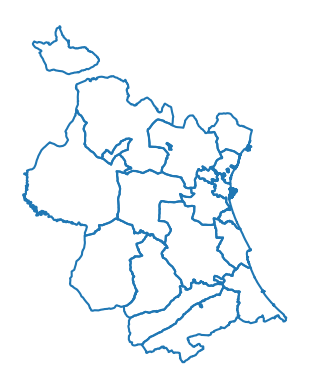

In [36]:
# Cargar el mapa de municipios
mapa_comarcas = gpd.read_file('datos/Delimitaciones_comarcales.geojson')

mapa_comarcas = mapa_comarcas[mapa_comarcas['provincia'] == 'València/Valencia']

fig = plt.figure()
ax = fig.add_subplot(111)
mapa_comarcas.boundary.plot(ax=ax)
plt.axis("off")
plt.show()


### 5.1 CREAR MAPAS

In [37]:
def crear_mapa(df, nombre_municipio_origen, fecha_inicio, tipo_anomalia):
    salto = pd.Timedelta("0 days 01:00:00")
    top_coords = [40.21, -1.21]  # Coordenadas ajustadas para la parte superior del mapa
    titulo_style = f'<div style="font-size: 14pt; color: black; white-space: nowrap;"><b>{nombre_municipio_origen} - {fecha_inicio} a {fecha_inicio+salto}</b></div>'
    
    m = folium.Map(location=[39.4699, -0.3763], zoom_start=9)
    
    if df.shape[0] > 0:

        max_displacements = df["N_Desplazamientos"].max()
        min_displacements = df["N_Desplazamientos"].min()

        for index, row in df.iterrows():
            # mid_coords = [(row['latitude_from'] + row['latitude_to']) / 2, 
            #               (row['longitude_from'] + row['longitude_to']) / 2]


            #weight_normalized = (row["N_Desplazamientos"]) / sum(df["N_Desplazamientos"]) + 1
            #weight_log = np.log10(row["N_Desplazamientos"])
            #weight_log = max(weight_log, 1)

            # Normalizar los desplazamientos al rango [0, 1]
            if max_displacements != min_displacements:
                normalized_displacement = (row["N_Desplazamientos"] - min_displacements) / (max_displacements - min_displacements)
            else:
                normalized_displacement = 0  # Si todos los desplazamientos son iguales, normalizar a 0
            
            # Escalar los valores normalizados al rango [2, 9]
            weight_scaled = 2 + normalized_displacement * 7

            #print("PESOS:",weight_scaled)

            folium.PolyLine(locations=[[row['latitude_from'], row['longitude_from']], 
                                        [row['latitude_to'], row['longitude_to']]], 
                            color='blue', weight=weight_scaled).add_to(m) #weight sirve para aumentar o disminuir el grosos de la flecha
            
            # folium.Marker(location=mid_coords, 
            #               icon=folium.DivIcon(html=f'<div style="font-size: 10pt; color: red;">{row["N_Desplazamientos"]}</div>')).add_to(m)
            
            folium.Marker(location=top_coords, 
                          icon=folium.DivIcon(html=titulo_style)).add_to(m)

        style_function = lambda x: {'color': 'black', 'weight': 2, 'fillOpacity': 0}
        folium.GeoJson(mapa_comarcas, style_function=style_function).add_to(m)

        bounds = mapa_comarcas.total_bounds.tolist()
        m.fit_bounds(bounds)

        img_data = m._to_png(5)
        img = Image.open(io.BytesIO(img_data))
        img.save(f'mapas/mapas_noviembre/{tipo_anomalia}/{nombre_municipio_origen.replace(" ", "_")}_{fecha_inicio.isoformat().replace(":", "_")}.png')

In [38]:
lista = movimientos_final["NomComarca_x"].unique()
lista

array(['El Rincón de Ademuz', 'La Safor', "La Vall d'Albaida",
       "L'Horta Oest", "L'Horta Sud", 'La Ribera Baixa',
       'El Camp de Morvedre', 'La Ribera Alta', 'La Hoya de Buñol',
       "L'Horta Nord", 'Los Serranos', 'La Canal de Navarrés',
       'El Valle de Cofrentes-Ayora', 'La Costera', 'El Camp de Túria',
       'La Plana de Utiel-Requena'], dtype=object)

### 5.2 BUCLE ITERATIVO PARA CREAR MAPAS

- COGER DESPLAZAMIENTOS DE 1 COMARCA DE ORIGEN A X COMARCAS
- SACAR CONTEO DE Nº DE DESPLAZAMIENTOS CADA HORA PARA:
  - DESPLAZAMIENTOS NORMALES
  - DESPLAZAMIENTOS ANOMALOS
- CREAR MAPAS PARA
  - DESPLAZAMIENTOS ANOMALOS
  - DESPLAZAMIENTOS NORMALES
- GUARDARLOS EN CARPETAS

In [40]:
movimientos_final["NomComarca_x"].unique()[9:]

array(["L'Horta Nord", 'Los Serranos', 'La Canal de Navarrés',
       'El Valle de Cofrentes-Ayora', 'La Costera', 'El Camp de Túria',
       'La Plana de Utiel-Requena'], dtype=object)

In [41]:
# RUTINA:
salto = pd.Timedelta("0 days 01:00:00") #conteos cada hora
lista = movimientos_final["NomComarca_x"].unique()

for i in movimientos_final["NomComarca_x"].unique()[9:]: #Recorremos todas comarcas de origen
    seguir=True
    fecha_inicio = movimientos_final["timestamp_from"].min()
    cont=1
    while seguir: #Iteramos hasta la fecha final de los datos
        nombre_comarca_origen = i
        print("COMARCA ORIGEN:",nombre_comarca_origen)
        datos = movimientos_final[movimientos_final["NomComarca_x"]==i]

        # Dataframe filtrado para [fecha_ini, fecha_fin]
        filas_en_rango = datos[(datos["timestamp_from"] >= fecha_inicio) & (datos["timestamp_from"] <= fecha_inicio+salto)] # si pongo fecha_final limito solo desplazamientos q duren 1 hora ajjajsj

        # Separamos df con datos anomalos y df con datos normales
        anomalos_tiempo = filas_en_rango[filas_en_rango["clase"]=="Anómalo_Tiempo"]
        anomalos_rural = filas_en_rango[filas_en_rango["clase"]=="Anómalo_Rural"]
        anomalos_laboral = filas_en_rango[filas_en_rango["clase"]=="Anómalo_Laboral"]
        normal = filas_en_rango[filas_en_rango["clase"]=="Normal"]

        conteo_anomalo_laboral = anomalos_laboral.groupby(['NomComarca_x', 'NomComarca_y'])['value_hash'].count().reset_index(name='N_Desplazamientos')
        conteo_anomalo_rural = anomalos_rural.groupby(['NomComarca_x', 'NomComarca_y'])['value_hash'].count().reset_index(name='N_Desplazamientos')
        conteo_anomalo_tiempo = anomalos_tiempo.groupby(['NomComarca_x', 'NomComarca_y'])['value_hash'].count().reset_index(name='N_Desplazamientos')
        conteo_normal = normal.groupby(['NomComarca_x', 'NomComarca_y'])['value_hash'].count().reset_index(name='N_Desplazamientos')
        print("NORMAL:",conteo_normal.shape, "ANOMALO LABORAL:",conteo_anomalo_laboral.shape,"ANOMALO RURAL:",conteo_anomalo_rural.shape,"ANOMALO TIEMPO:",conteo_anomalo_tiempo.shape)

        ##################################### UNIR VARIABLES PERDIDAS AL REALIZAR EL CONTEO ####################

        # Cogemos los valores unicos de cada deplazamiento intermunicipal
        valores_unicos = filas_en_rango['NomComarca_x'].dropna().unique()
        filas_unicas_origen = filas_en_rango.groupby('NomComarca_x').first().loc[valores_unicos].reset_index()

        # Unimos las variables perdidas para el origen de cada desplazamiento
        df_anomalo_tiempo = pd.merge(conteo_anomalo_tiempo,filas_unicas_origen[["NomComarca_x","Municipio_Origen","latitude_from","longitude_from"]], on=['NomComarca_x'])
        df_anomalo_laboral = pd.merge(conteo_anomalo_laboral,filas_unicas_origen[["NomComarca_x","Municipio_Origen","latitude_from","longitude_from"]], on=['NomComarca_x'])
        df_anomalo_rural = pd.merge(conteo_anomalo_rural,filas_unicas_origen[["NomComarca_x","Municipio_Origen","latitude_from","longitude_from"]], on=['NomComarca_x'])
        df_normal = pd.merge(conteo_normal,filas_unicas_origen[["NomComarca_x","Municipio_Origen","latitude_from","longitude_from"]], on=['NomComarca_x'])

        # Cogemos los valores unicos de cada deplazamiento intermunicipal
        valores_unicos = filas_en_rango['NomComarca_y'].dropna().unique()
        filas_unicas_destino = filas_en_rango.groupby('NomComarca_y').first().loc[valores_unicos].reset_index()

        # Unimos las variables perdidas para el destino de cada desplazamiento
        df_anomalo_tiempo = pd.merge(df_anomalo_tiempo,filas_unicas_destino[["NomComarca_y","Municipio_Destino","latitude_to","longitude_to"]], on=['NomComarca_y'])
        df_anomalo_laboral = pd.merge(df_anomalo_laboral,filas_unicas_destino[["NomComarca_y","Municipio_Destino","latitude_to","longitude_to"]], on=['NomComarca_y'])
        df_anomalo_rural = pd.merge(df_anomalo_rural,filas_unicas_destino[["NomComarca_y","Municipio_Destino","latitude_to","longitude_to"]], on=['NomComarca_y'])
        df_normal = pd.merge(df_normal,filas_unicas_destino[["NomComarca_y","Municipio_Destino","latitude_to","longitude_to"]], on=['NomComarca_y'])

        # Agrergamos la fecha de inicio
        df_normal['Tiempo_base'] = fecha_inicio
        df_anomalo_laboral['Tiempo_base'] = fecha_inicio
        df_anomalo_rural['Tiempo_base'] = fecha_inicio
        df_anomalo_tiempo['Tiempo_base'] = fecha_inicio

        # ############################################# MAPAS #########################################################
        crear_mapa(df_anomalo_tiempo, nombre_comarca_origen, fecha_inicio, "anomalas_tiempo")
        crear_mapa(df_anomalo_laboral, nombre_comarca_origen, fecha_inicio, "anomalas_laboral")
        crear_mapa(df_anomalo_rural, nombre_comarca_origen, fecha_inicio, "anomalas_rural")
        crear_mapa(df_normal, nombre_comarca_origen, fecha_inicio, "normales")

        ############################################### FECHAS #####################################################
        print("FECHA INICIO",fecha_inicio)
        print("------------------------------")

        # Actualizamos fechas y volvemos a iterar con las nuevas fechas:
        fecha_inicio = fecha_inicio + salto
        
        ################################### CONDICION DE PARADA Y ACLARADO DE CHUNK ################################
        if fecha_inicio >= movimientos["timestamp_from"].max(): #pd.to_datetime("2023-11-10 00:00:00")
            seguir = False
        if cont == 4:
            clear_output(wait=True)
            cont=1
        cont+=1

COMARCA ORIGEN: La Costera
NORMAL: (16, 3) ANOMALO LABORAL: (2, 3) ANOMALO RURAL: (6, 3) ANOMALO TIEMPO: (0, 3)
FECHA INICIO 2023-11-08 13:00:00
------------------------------
COMARCA ORIGEN: La Costera
NORMAL: (16, 3) ANOMALO LABORAL: (6, 3) ANOMALO RURAL: (7, 3) ANOMALO TIEMPO: (0, 3)
FECHA INICIO 2023-11-08 14:00:00
------------------------------
COMARCA ORIGEN: La Costera
NORMAL: (16, 3) ANOMALO LABORAL: (5, 3) ANOMALO RURAL: (6, 3) ANOMALO TIEMPO: (0, 3)


NoSuchWindowException: Message: Browsing context has been discarded
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:191:5
NoSuchWindowError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:662:5
assert.that/<@chrome://remote/content/shared/webdriver/Assert.sys.mjs:485:13
assert.open@chrome://remote/content/shared/webdriver/Assert.sys.mjs:147:4
GeckoDriver.prototype.navigateTo@chrome://remote/content/marionette/driver.sys.mjs:816:39
despatch@chrome://remote/content/marionette/server.sys.mjs:318:40
execute@chrome://remote/content/marionette/server.sys.mjs:289:16
onPacket/<@chrome://remote/content/marionette/server.sys.mjs:262:20
onPacket@chrome://remote/content/marionette/server.sys.mjs:263:9
_onJSONObjectReady/<@chrome://remote/content/marionette/transport.sys.mjs:494:20
